In [15]:
#Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
import tensorflow as tf
from itertools import islice
import glob
from PIL import Image
import cv2 as cv
import random
from tensorflow.keras.utils import Sequence
from skimage.color import rgb2gray

In [3]:
#Checking for GPU

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# Meta data
data=pd.read_csv(r"/content/drive/MyDrive/sign_data/train_data.csv")

In [22]:
data

,Item 1,Item 2,Label
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1
...,...,...,...
23201,031/02_031.png,031/03_031.png,0
23202,031/02_031.png,031/12_031.png,0
23203,031/02_031.png,031/11_031.png,0
23204,031/02_031.png,031/06_031.png,0


### Preparing the Siamese dataset

In [16]:
"""
The siamese network is usually a multi input model, where two or more than two inputs are provided to the model. In our case the inputs will be a pair of images which the model
needs to predict are similar or different.

"""

' \nThe siamese network is usually a multi input model, where two or more than two inputs are provided to the model. In our case the inputs will be a pair of images which the model \nneeds to predict are similar or different.\n\n'

In [23]:
#Declaring base directories
base_dir=r"/content/drive/MyDrive/sign_data"
train_dir=r"/content/drive/MyDrive/sign_data/train"

In [24]:
def img_paths(data,dir):

  """
  Description: Function to get turn the individual image paths into pairs of image paths

  Input: Original paths and image directory
  Output: List of paired image paths along with labels of similar or not

  """
  originals=data["Item 1"]
  pairs=data["Item 2"]

  image_paths=[]
  i=0
  for original,pair in zip(originals,pairs):
    path_original=os.path.join(train_dir,original)
    path_pair=os.path.join(train_dir,pair)
    image_paths.append((path_original,path_pair))

  labels=data["Label"]
  labels=np.array(labels)
  labels=labels.astype('float32')

  return image_paths,labels

In [25]:
#Getting the paired image paths
image_paths,label=img_paths(data,train_dir)

In [26]:
from sklearn.model_selection import train_test_split
def get_paths(image_paths,label,split=0):
  train,test,y_train,y_test=train_test_split(image_paths,label,test_size=split,shuffle=True,random_state=42)
  return train,test,y_train,y_test

train_paths,valid_paths,y_train,y_valid=get_paths(image_paths,label,split=0.2)

In [27]:
class SiameseDataGenerator(Sequence):
    """
    Description: This is a custom image generator class which will allow us to yeild the pairs of images from the directory without loading
    the entire dataset onto disk.

    """
    def __init__(self, image_paths, labels, batch_size, image_size):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.indexes = np.arange(len(self.image_paths))

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        """
        Description: Function to seperate the images into batches based on the batch size

        Input: Index from where the next batch starts
        Output: Batch of images based on the batch size

        """
        start = index * self.batch_size
        end = (index + 1) * self.batch_size

        batch_paths = self.image_paths[start:end]
        batch_labels = self.labels[start:end]

        X1, X2, y = [], [], []

        for i in range(len(batch_paths)):
            img_path1, img_path2 = batch_paths[i]
            label = batch_labels[i]

            # Load and preprocess images
            image1 = self.load_and_preprocess_image(img_path1)
            image2 = self.load_and_preprocess_image(img_path2)

            X1.append(image1)
            X2.append(image2)
            y.append(label)

        return [np.array(X1), np.array(X2)], np.array(y)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

    def load_and_preprocess_image(self, img_path):
        """
        Description: Function to pre-process the images as required

        Input: Image path
        Output: Pre-processed image

        """
        image = cv.imread(img_path)
        image = cv.resize(image, self.image_size)
        image=cv.cvtColor(image,cv.COLOR_BGR2RGB)
        image=cv.cvtColor(image,cv.COLOR_RGB2GRAY)
        _,image=cv.threshold(image,128,255,cv.THRESH_OTSU+cv.THRESH_BINARY_INV)
        image = image / np.std(image)


        return image




In [28]:
# label description: (0 for similar pairs, 1 for dissimilar pairs)

#Getting training and validation generator also declaring necessary parameters

batch_size = 64
image_size = (155, 220)
train_data_generator = SiameseDataGenerator(train_paths, y_train, batch_size, image_size)
valid_data_generator = SiameseDataGenerator(valid_paths, y_valid, batch_size, image_size)

In [73]:
def display_img(data_generator,count=0):

  """
  Description: Function to display a given number of the paired images

  Input: Data generator, Count of images to display
  Output: Displays images

  """
  enough=False
  for batch_x, batch_y in data_generator:
      print(np.array(batch_x).shape)
      for i in range(len(batch_x[0])):
        image_1=batch_x[0][i]
        image_2=batch_x[1][i]

        label = batch_y[i]

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image_1,cmap='gray')
        plt.title(f"Image 1 - Label: {label}")

        plt.subplot(1, 2, 2)
        plt.imshow(image_2,cmap='gray')
        plt.title(f"Image 2 - Label: {label}")

        plt.show()
        if i==count:
          enough=True
          break
      if enough==True:
        break

      print(f"Batch X1 shape: {batch_x[0].shape}, Batch X2 shape: {batch_x[1].shape}, Batch y shape: {batch_y.shape}")

### Model Buidling

In [6]:
def siamese_network():

    """
    Description: Base model function to generate the encoding for each image

    Input:
    Output: Base Model

    """
    inputs=tf.keras.Input(shape=(155,220,1))
    x=tf.keras.layers.Conv2D(96,(11,11),strides=1,padding='valid',input_shape=(155,220,1),activation='relu')(inputs)
    x=tf.keras.layers.Lambda(lambda x:tf.nn.local_response_normalization(x,depth_radius=2,bias=2, alpha=0.0001, beta=0.75))(x)
    x=tf.keras.layers.MaxPooling2D((3,3),strides=2)(x)

    x=tf.keras.layers.Conv2D(256,(5,5),strides=1,padding='valid',activation='relu')(x)
    x=tf.keras.layers.Lambda(lambda x:tf.nn.local_response_normalization(x,depth_radius=2,bias=2, alpha=0.0001, beta=0.75))(x)
    x=tf.keras.layers.MaxPooling2D((3,3),strides=2)(x)
    x=tf.keras.layers.Dropout(0.3)(x)

    x=tf.keras.layers.Conv2D(384,(3,3),strides=1,padding='valid',activation='relu')(x)

    x=tf.keras.layers.Conv2D(256,(3,3),strides=1,padding='valid',activation='relu')(x)
    x=tf.keras.layers.MaxPooling2D((3,3),strides=2)(x)
    x=tf.keras.layers.Dropout(0.3)(x)

    x=tf.keras.layers.Flatten()(x)
    x=tf.keras.layers.Dense(1024,activation='relu')(x)
    x=tf.keras.layers.Dropout(0.5)(x)

    x=tf.keras.layers.Dense(128,activation='relu')(x)

    return tf.keras.Model(inputs=inputs,outputs=x)


In [7]:
def euclidian_distance(encodings):
    """
    Description: Function to calculate the euclidean distance between the image encodings

    Input: Encodings
    Output: Euclidean Distance

    """
    encode_a,encode_b=encodings
    sum_squares=tf.keras.backend.sum(tf.keras.backend.square(encode_a-encode_b),axis=1, keepdims=True)
    d=tf.keras.backend.sqrt(tf.keras.backend.maximum(sum_squares,tf.keras.backend.epsilon()))

    return d

def euclidian_shape(shapes):
    shape1,shape2=shapes
    return (shape1[0],1)

In [8]:
#Loading base model
base_model=siamese_network()

In [9]:
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 155, 220, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 145, 210, 96)      11712     
                                                                 
 lambda (Lambda)             (None, 145, 210, 96)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 72, 104, 96)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 68, 100, 256)      614656    
                                                                 
 lambda_1 (Lambda)           (None, 68, 100, 256)      0         
                                                             

In [10]:
#Setting up inputs and output of the siamese network
input_a=tf.keras.layers.Input(shape=(155,220,1), name='left_input')
input_b=tf.keras.layers.Input(shape=(155,220,1), name='right_input')

vect_a=base_model(input_a)
vect_b=base_model(input_b)

In [11]:
#Final siamese network
output=tf.keras.layers.Lambda(euclidian_distance,name='output_layer',output_shape=euclidian_shape)([vect_a,vect_b])
model=tf.keras.Model([input_a,input_b],output)

In [12]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 left_input (InputLayer)     [(None, 155, 220, 1)]        0         []                            
                                                                                                  
 right_input (InputLayer)    [(None, 155, 220, 1)]        0         []                            
                                                                                                  
 model (Functional)          (None, 128)                  8326905   ['left_input[0][0]',          
                                                          6          'right_input[0][0]']         
                                                                                                  
 output_layer (Lambda)       (None, 1)                    0         ['model[0][0]',         

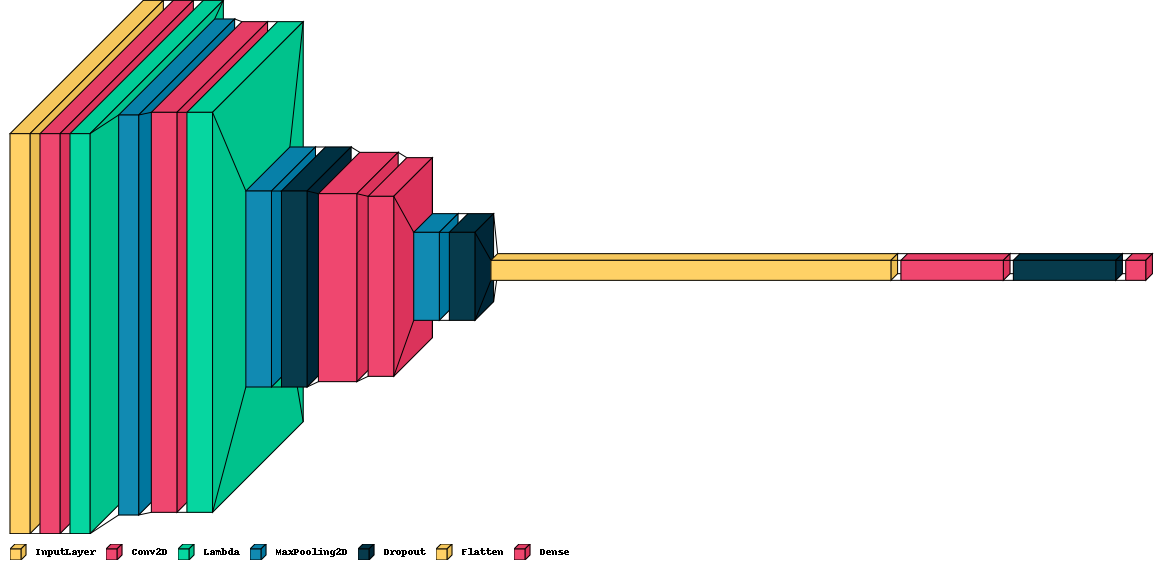

In [131]:
import visualkeras
visualkeras.layered_view(base_model,max_xy=400,legend=True,)

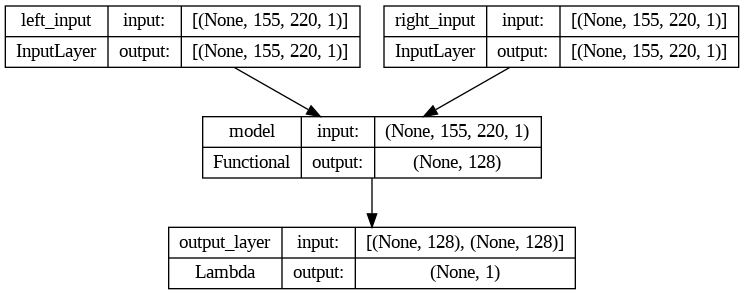

In [ ]:
#Visualizing the model
tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True,to_file='outer-model.png')

In [ ]:
#Contrastive loss:-L = (1-Y) * ||x_i - x_j||^2 + Y * max(0, m - ||x_i - x_j||^2) #x_i and x_j are the vector encodings we receive from our siamese model
def contrastive_loss_margin(margin):
    #This is a wrapper surrounding our self defined loss function which helps to pass parameters to the loss function

    """
    Description: Function to calculate the contrastive loss

    Input: Margin of euclidean distance to determine positive or negative pair of images
    Output: Contrastive loss

    """
    def contrastive_loss(y_true,y_pred):
        square_pred=tf.keras.backend.square(y_pred)  #||x_i - x_j||^2

        margin_square=tf.keras.backend.square(tf.keras.backend.maximum(margin-y_pred,0)) #max(0, m - ||x_i - x_j||^2) m=margin

        return tf.keras.backend.mean(y_true*margin_square+(1-y_true)*square_pred)

    return contrastive_loss

In [ ]:
"""
Testing out different optimizers RMSProp worked the best in this case  and for the metric we will currently use accuracy

"""
rms=tf.keras.optimizers.RMSprop()
model.compile(optimizer=rms,loss=contrastive_loss_margin(margin=1),metrics=['accuracy'])
callback=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=False,
)

In [ ]:
#Training the model

history=model.fit(train_data_generator,epochs=20,batch_size=64,validation_data=(valid_data_generator),callbacks=callback)

In [13]:
model.load_weights('/content/drive/MyDrive/sign_data/SigNet.h5')

In [29]:
y_pred_valid=model.predict(valid_data_generator)

73/73 [==============================] - 1295s 18s/step


### Evaluating performance

In [52]:
#importing libraries for evaluation

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [31]:
def calc_accuracy(predictions,y_true):

  """
  Description: Function to calculate accuracy based on True Positive Rate and True Negative Rate

  Input: predictions and true values
  Output: Accuracy

  """
  rho_similar=list(y_true).count(0)
  rho_dissimilar=list(y_true).count(1)

  CM = confusion_matrix(y_true, predictions)

  TP = CM[0][0]
  FP = CM[1][0]
  TN = CM[1][1]
  FN = CM[0][1]


  TPR=TP/rho_similar
  TNR=TN/rho_dissimilar

  accuracy=0.5*(TPR+TNR)
  return accuracy

In [32]:
def evaluate(y_pred,y_true):

  """
  Description: Function to generate the best margin threshold of the model

  Input: predictions and true values
  Output: Optimum margin value and the accurace at that margin

  """
  predictions=[x[0] for x in y_pred]

  minimum=min(predictions)
  maximum=max(predictions)

  thresholds=np.arange(minimum,maximum+0.01,0.01)
  max_accuracy=float('-inf')

  for i,thresh in enumerate(thresholds):
    pred=[]
    for vals in predictions:

      if vals<=thresh:pred.append(0)
      else:pred.append(1)

    accuracy=calc_accuracy(pred,y_true)

    if accuracy>max_accuracy:
      max_accuracy=accuracy
      distance=thresh

  return max_accuracy,distance



In [33]:
print(f'accuracy:{evaluate(y_pred_valid,y_valid)}')

accuracy:(0.7915129172005797, 0.33338097102940084)


In [54]:
#Model threshold
Threshold=0.33338097102940084

In [ ]:
predictions=[x[0] for x in y_pred_valid]
pred=[]
for vals in predictions:
      if vals<=Threshold:pred.append(0)
      else:pred.append(1)

In [35]:
#Viewing classification report
cr=classification_report(y_valid,pred)
print(cr)

              precision    recall  f1-score   support

         0.0       0.79      0.87      0.82      2528
         1.0       0.82      0.72      0.76      2114

    accuracy                           0.80      4642
   macro avg       0.80      0.79      0.79      4642
weighted avg       0.80      0.80      0.80      4642



### Predicting test data

In [38]:
data_test=pd.read_csv(r"/content/drive/MyDrive/sign_data/test_data.csv")

In [39]:
data_test

,Item 1,Item 2,Label
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1
...,...,...,...
5743,066/01_066.png,066/06_066.png,0
5744,066/01_066.png,066/08_066.png,0
5745,066/01_066.png,066/02_066.png,0
5746,066/01_066.png,066/05_066.png,0


In [40]:
test_dir='/content/drive/MyDrive/sign_data/test'

In [41]:
labels_test=data_test['Label']

In [42]:
test_paths,labels_test=img_paths(data_test,test_dir)

In [43]:
batch_size = 64
image_size = (155, 220)  # Set the desired image size
test_data_generator = SiameseDataGenerator(test_paths,labels_test, batch_size, image_size)

(2, 64, 220, 155)


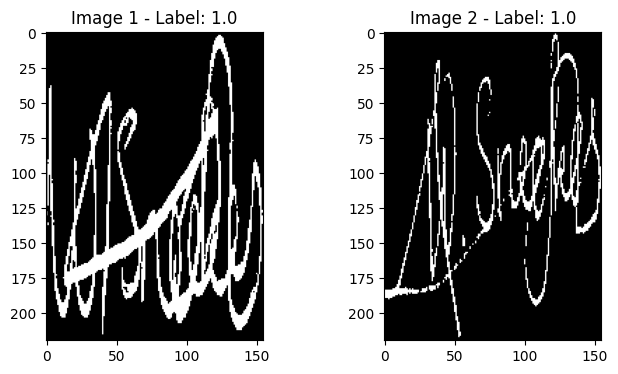

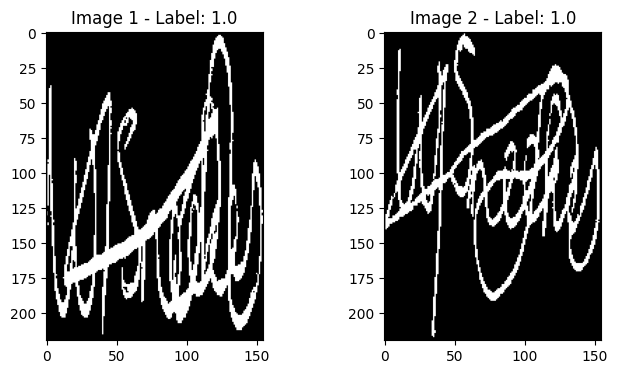

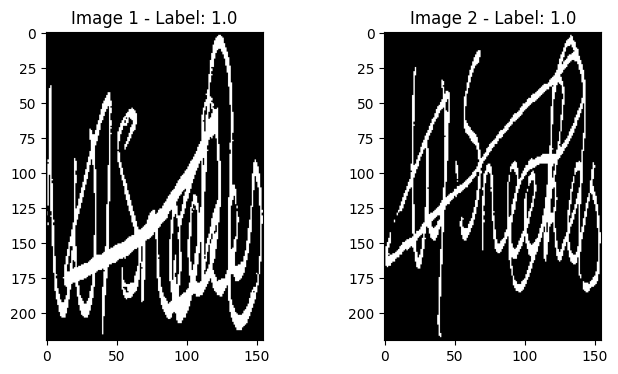

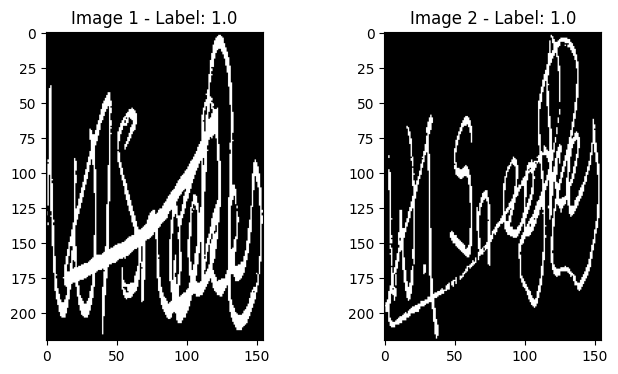

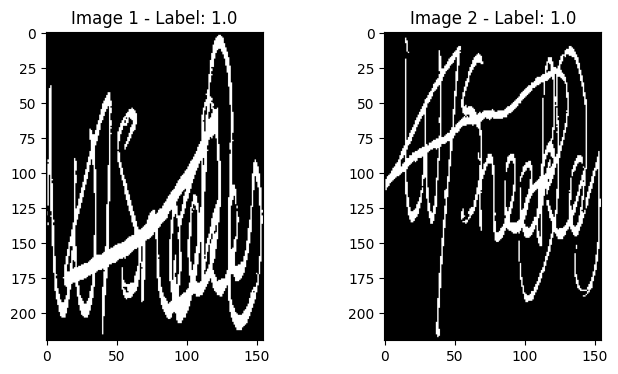

In [93]:
#Viewing test images
display_img(test_data_generator,count=4)

In [46]:
#Checking score on test set
test_pred=model.predict(test_data_generator)
print(f'accuracy:{evaluate(test_pred,labels_test)}')

accuracy:(0.7684899106270073, 0.3319645725935698)


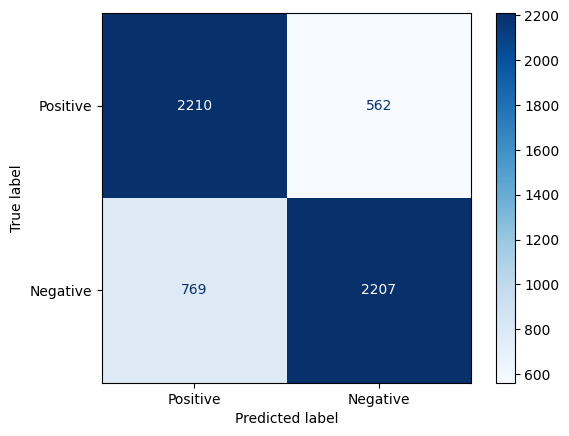

In [56]:
#Plotting confusion matrix on test set

y_pred_test=[ 1 if pred>=Threshold else 0 for pred in test_pred]
cm = confusion_matrix(labels_test, y_pred_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Positive", "Negative"])
cm_display.plot(cmap=plt.cm.Blues)
plt.show()


### Custom dataset

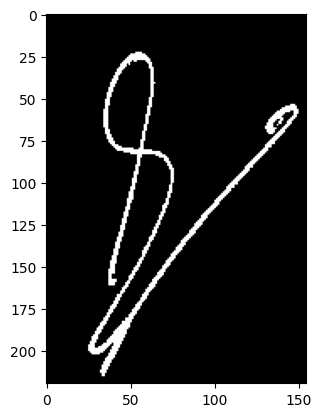

In [ ]:
image=cv.cvtColor(test_img,cv.COLOR_BGR2RGB)
image = cv.resize(image, (155,220))
image=cv.cvtColor(image,cv.COLOR_RGB2GRAY)
_,image=cv.threshold(image,128,255,cv.THRESH_OTSU+cv.THRESH_BINARY_INV)
image = image / np.std(image)
plt.imshow(image,cmap='gray')

In [ ]:
batch_size = 1
image_size = (155, 220)  # Set the desired image size
test_generator = SiameseDataGenerator(test_path,labels_test, batch_size, image_size)

In [ ]:
test_path=[('/IMG20230920225529_BURST001_COVER.jpg','/IMG20230920225529_BURST001_COVER.jpg')]

In [ ]:
model.predict(test_generator)

1/1 [==============================] - 1s 1s/step


array([[0.00031623]], dtype=float32)

In [59]:
original='/content/drive/MyDrive/Test/IMG20230920225529_BURST001_COVER.jpg'

In [112]:
dir='/content/drive/MyDrive/Test/Forged'
files=os.listdir(dir)
files=[os.path.join(dir,f) for f in files]

In [119]:
data_test=[(original,f) for f in files]
data_test
labels_t=[0,1,1,1,1,1,1,1,0]

In [114]:
batch_size = 1
image_size = (155, 220)  # Set the desired image size
custom_test_generator = SiameseDataGenerator(data_test,labels_t, batch_size, image_size)

In [115]:
print(test_generator.image_paths)

[('/content/drive/MyDrive/Test/IMG20230920225529_BURST001_COVER.jpg', '/content/drive/MyDrive/Test/Forged/IMG20230920225529_BURST001_COVER.jpg'), ('/content/drive/MyDrive/Test/IMG20230920225529_BURST001_COVER.jpg', '/content/drive/MyDrive/Test/Forged/IMG20230921142658.jpg'), ('/content/drive/MyDrive/Test/IMG20230920225529_BURST001_COVER.jpg', '/content/drive/MyDrive/Test/Forged/IMG20230921142657.jpg'), ('/content/drive/MyDrive/Test/IMG20230920225529_BURST001_COVER.jpg', '/content/drive/MyDrive/Test/Forged/IMG20230921142656.jpg'), ('/content/drive/MyDrive/Test/IMG20230920225529_BURST001_COVER.jpg', '/content/drive/MyDrive/Test/Forged/IMG20230921142655.jpg'), ('/content/drive/MyDrive/Test/IMG20230920225529_BURST001_COVER.jpg', '/content/drive/MyDrive/Test/Forged/IMG20230921142654.jpg'), ('/content/drive/MyDrive/Test/IMG20230920225529_BURST001_COVER.jpg', '/content/drive/MyDrive/Test/Forged/IMG20230921142659.jpg'), ('/content/drive/MyDrive/Test/IMG20230920225529_BURST001_COVER.jpg', '/con

(2, 1, 220, 155)


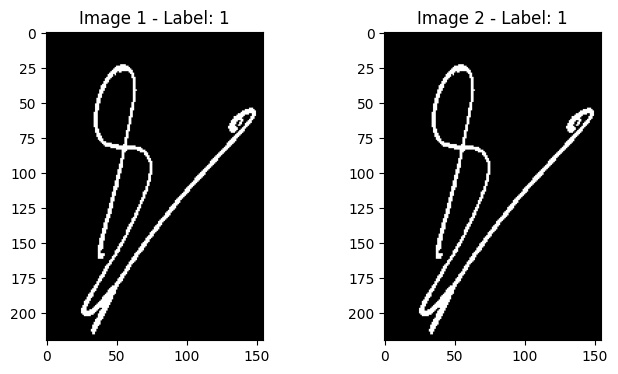

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


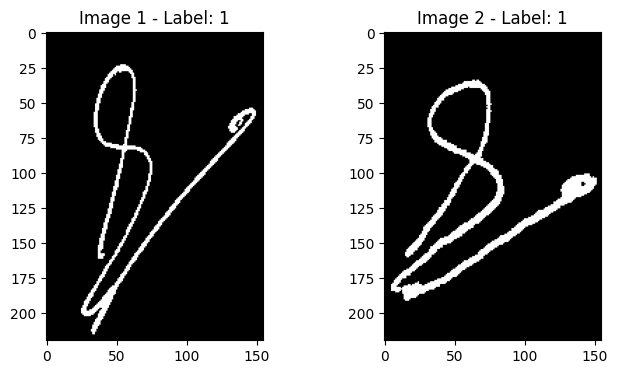

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


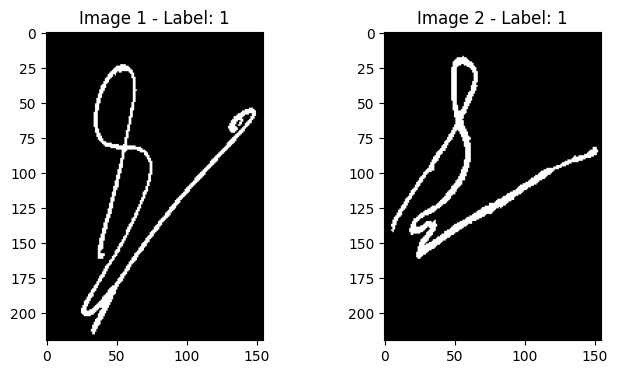

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


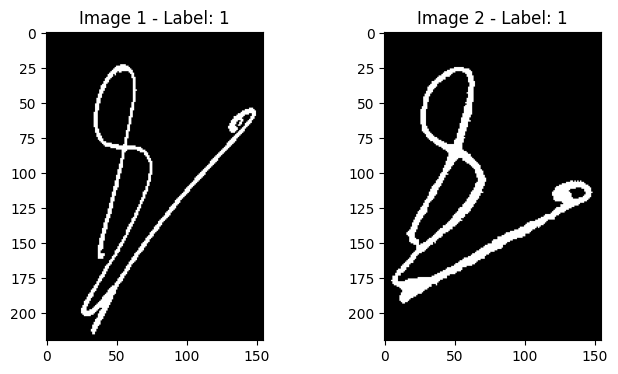

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


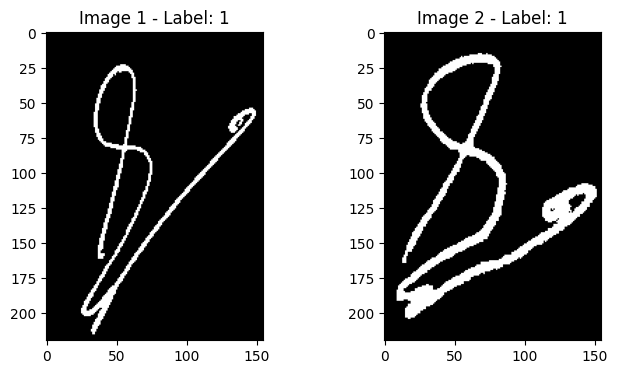

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


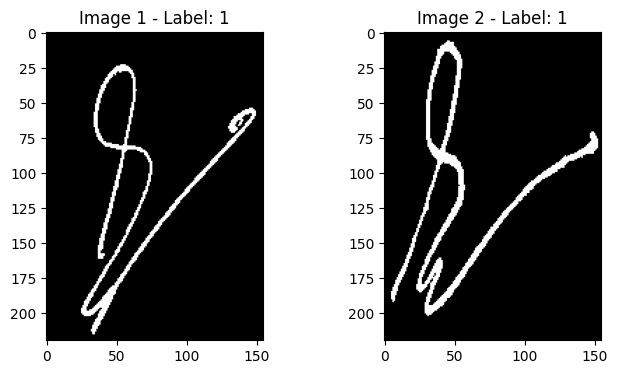

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


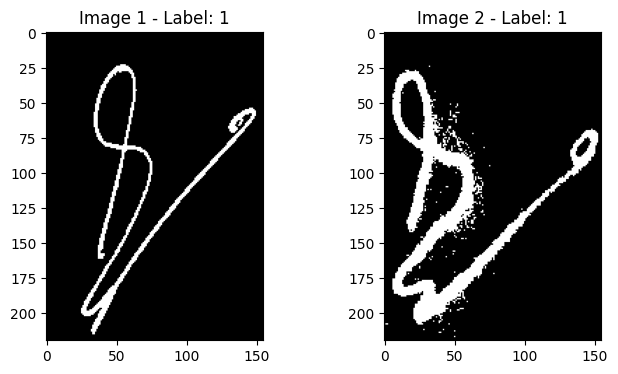

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


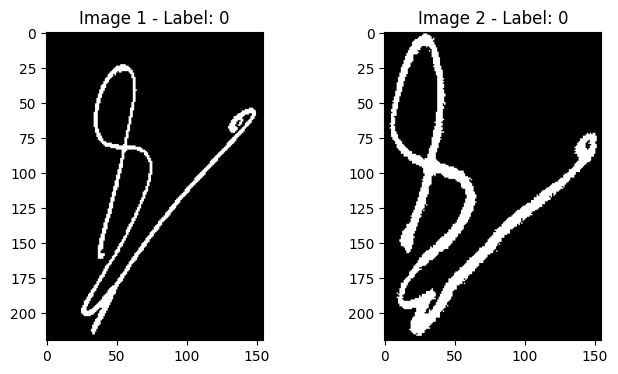

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)
(2, 1, 220, 155)


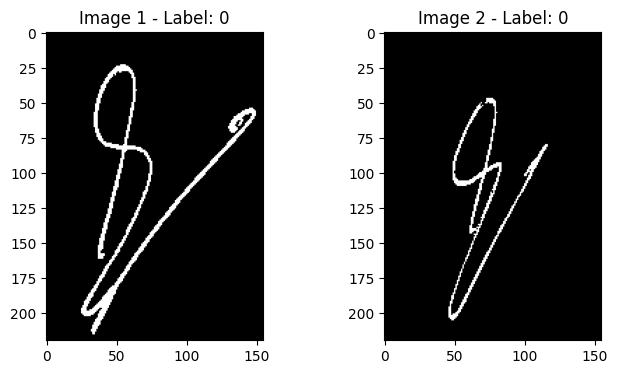

Batch X1 shape: (1, 220, 155), Batch X2 shape: (1, 220, 155), Batch y shape: (1,)


In [116]:
display_img(test_generator,count=9)

In [117]:
predictions=model.predict(custom_test_generator)

9/9 [==============================] - 0s 49ms/step


In [118]:
evaluate(predictions,labels_t)

(0.7857142857142857, 0.2903162277571391)

In [69]:
pred=[]
for vals in predictions:
      if vals<=Threshold:pred.append(0)
      else:pred.append(1)
pred

[0, 1, 0, 0, 0, 0, 1, 1, 0]